# GMFD yield calculation

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy import interpolate
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

In [2]:
precip = xr.open_dataset('../../netCDF/cuml_precip_gs_GMFD.nc')
gdd = xr.open_dataset('../../netCDF/GDD_10-29C_gs_GMFD.nc')
egdd = xr.open_dataset('../../netCDF/GDD_29C_gs_GMFD.nc')

In [15]:
weights = pd.read_csv('../grids/gmfd/output/counties_GMFD_weighted.csv')
weights['GEOID'] = weights['GEOID'].astype(str).str.zfill(5)

In [4]:
final = precip.copy()

In [5]:
final

<xarray.Dataset>
Dimensions:  (lat: 600, lon: 1440, time: 61)
Coordinates:
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) int32 1956 1957 1958 1959 1960 ... 2012 2013 2014 2015 2016
Data variables:
    prcp     (time, lat, lon) float64 ...
Attributes:
    description:  Growing season total precipitation

In [6]:
# Impact functions
east_west_meridian = np.argmax(final["lon"].values > 260.)
print("East/West divide is at longitude point: " + str(east_west_meridian))

Ealpha = 0.00031309187
Ebeta = -0.0061613785

Walpha = 0.00026968688416391184
Wbeta = -0.00299402820671972

Eprecip_x = np.load("../response/output/maize_east_precip_x.npy")
Eprecip_y = np.load("../response/output/maize_east_precip_y.npy")

Wprecip_x = np.load("../response/output/maize_west_precip_x.npy")
Wprecip_y = np.load("../response/output/maize_west_precip_y.npy")

Eprecip_interp = interpolate.interp1d(np.insert(Eprecip_x, 0, 0., axis=0), np.insert(Eprecip_y[:,0], 0, 0., axis=0), fill_value = "extrapolate", bounds_error = False)
Wprecip_interp = interpolate.interp1d(np.insert(Wprecip_x, 0, 0., axis=0), np.insert(Wprecip_y[:,0], 0, 0., axis=0), fill_value = "extrapolate", bounds_error = False)

# Apply impact functions
final["Eimpact"] = (Ealpha * gdd["GDD"]) + (Ebeta * egdd["GDD"]) + Eprecip_interp(precip["prcp"])
final["Wimpact"] = (Walpha * gdd["GDD"]) + (Wbeta * egdd["GDD"]) + Wprecip_interp(precip["prcp"])

East/West divide is at longitude point: 1040


In [7]:
# Set time range
yearMin = 1956
yearMax = 2016
tbound = [yearMin,yearMax]

# Build index structure for dataframe
unique_geoids = np.load("../USDA/usda_grab/output/unique_geoids.npy", allow_pickle=True)
years = np.arange(yearMin, yearMax+1, 1)

unique_geoids = [[unique_geoid]*len(years) for unique_geoid in unique_geoids]
unique_geoids = np.ndarray.flatten(np.asarray(unique_geoids))

years = [years] * len(unique_geoids)
years = np.ndarray.flatten(np.asarray(years))

tuples = list(zip(*[unique_geoids, years]))

index = pd.MultiIndex.from_tuples(tuples)

# Build empty dataframe with complete indexing
proj_final = pd.DataFrame(index = index)
proj_final.index.names = ["GEOID", "Year"]
proj_final["projected"] = 0.

In [8]:
final

<xarray.Dataset>
Dimensions:  (lat: 600, lon: 1440, time: 61)
Coordinates:
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) int32 1956 1957 1958 1959 1960 ... 2012 2013 2014 2015 2016
Data variables:
    prcp     (time, lat, lon) float64 ...
    Eimpact  (time, lat, lon) float64 0.2522 0.2508 0.2494 ... 0.1033 0.1031
    Wimpact  (time, lat, lon) float64 0.1834 0.1823 0.1812 ... 0.07162 0.07147
Attributes:
    description:  Growing season total precipitation

In [23]:
weights = weights.groupby(['GEOID', 'latitude', 'longitude']).sum().reset_index().drop(columns = ['STATEFP', 'COUNTYFP'])

In [29]:
weights.head()

,GEOID,latitude,longitude,within_county_weight
0,01001,369,1092,0.101116
1,01001,369,1093,0.298316
2,01001,369,1094,0.113768
3,01001,370,1092,0.061811
4,01001,370,1093,0.302705


In [32]:
# Calulate projections
for geoid in proj_final.index.unique(level = "GEOID"):
    pd_temp = weights[weights.GEOID == geoid]
    for year in proj_final.index.unique(level = "Year"):
        temp = 0
        for index, row in pd_temp.iterrows():
            if row["longitude"] >= east_west_meridian:
                temp += (final.isel(lat = row["latitude"], lon = row["longitude"], time = year-yearMin)["Eimpact"] * row["within_county_weight"])
            elif row["longitude"] < east_west_meridian:
                temp += (final.isel(lat = row["latitude"], lon = row["longitude"], time = year-yearMin)["Wimpact"] * row["within_county_weight"])
        proj_final.loc[geoid, year]["projected"] = temp

In [38]:
proj_final.tail()

projected
GEOID Year           
56045 2012   0.201856
      2013   0.350464
      2014   0.400217
      2015   0.442177
      2016   0.330661

In [37]:
proj_final.to_csv('./output/gmfd_yield_historical.csv')

## Checking within county weighting scheme

In [18]:
gmfd = pd.read_csv('gmfd_yield_area_weights.csv')
gmfd['GEOID'] = gmfd['GEOID'].astype(str).str.zfill(5)
gmfd.set_index(["GEOID", "Year"], inplace = True)
gmfd.drop(index = [2017, 2018], level = 1, inplace = True)

In [19]:
gmfd.head()

projected
GEOID Year           
01001 1956   0.268606
      1957   0.411497
      1958   0.471879
      1959   0.286835
      1960   0.329027

In [10]:
# USDA
usda_weights = pd.read_csv("../analysis/weights/usda_county_to_national_weights.csv")
usda_weights["GEOID"] = usda_weights["GEOID"].astype(str).str.zfill(5)

In [13]:
# Read in USDA data
usda = pd.read_csv("../data/USDA/final/USDA_county_yields_w_county_trends.csv")
usda["state_fips_code"] = usda["state_fips_code"].astype(str).str.zfill(2)
usda["county_code"] = usda["county_code"].astype(str).str.zfill(3)
usda["GEOID"] = usda["state_fips_code"] + usda["county_code"]
usda["GEOID"] = usda["GEOID"].astype(str).str.zfill(5)
usda.set_index(["GEOID", "year"], inplace = True)

In [14]:
usda.head()

,,state_fips_code,county_code,asd_code,Value,area,log_Value,lowess_log_Value,target_Value
GEOID,year,,,,,,,,
01001,1950,01,001,40,17.0,29600.0,2.833213,2.922636,-0.089422
01011,1950,01,011,40,11.0,24200.0,2.397895,2.684326,-0.286430
01047,1950,01,047,40,13.0,44200.0,2.564949,2.724326,-0.159377
01051,1950,01,051,40,23.0,38900.0,3.135494,3.057709,0.077785
01063,1950,01,063,40,16.0,23900.0,2.772589,2.724703,0.047885


In [20]:
# Offset by means (equivalent to minimising sum of square of residuals)
gmfd["projected_offset"] = 0.0

for geoid in usda.index.unique(level = "GEOID"):
    if geoid in gmfd.index:
        model_mean = gmfd.loc[geoid]["projected"].mean()
        data_mean = usda.loc[geoid].query("year >= 1960 and year <= 2016")["target_Value"].mean()
    
        gmfd.loc[geoid]["projected_offset"] = gmfd.loc[geoid]["projected"] - model_mean + data_mean

In [21]:
gmfd.head()

projected  projected_offset
GEOID Year                             
01001 1956   0.268606         -0.217247
      1957   0.411497         -0.074357
      1958   0.471879         -0.013974
      1959   0.286835         -0.199019
      1960   0.329027         -0.156826

In [22]:
# USDA only
usda_nat = pd.merge(usda_weights.filter(["GEOID","year","national_weight"]), usda.reset_index().filter(["GEOID","year","target_Value"]), on = ["GEOID","year"], how = "outer")
usda_nat["yield_USDA_nationally_weighted"] = usda_nat["national_weight"] * usda_nat["target_Value"]
usda_nat = usda_nat.groupby("year").sum().drop(columns = ["national_weight", "target_Value"])

In [24]:
# Merge
gmfd_all = pd.merge(gmfd.reset_index(), usda_weights, left_on = ["GEOID", "Year"], right_on = ["GEOID", "year"], how = "inner", copy = False).drop_duplicates()
gmfd_all = pd.merge(gmfd_all, usda, left_on = ["GEOID", "Year", "Value", "area"], right_on = ["GEOID", "year", "Value", "area"], how = "inner", copy = False).drop_duplicates()

In [25]:
gmfd_all.head()

,GEOID,Year,projected,projected_offset,year,Value,area,national_weight,state_fips_code,county_code,asd_code,log_Value,lowess_log_Value,target_Value
0,01001,1956,0.268606,-0.217247,1956,24.0,21100.0,0.000169,01,001,40,3.178054,3.134604,0.043450
1,01001,1957,0.411497,-0.074357,1957,22.0,22300.0,0.000168,01,001,40,3.091042,3.168767,-0.077725
2,01001,1958,0.471879,-0.013974,1958,32.0,22600.0,0.000221,01,001,40,3.465736,3.202644,0.263092
3,01001,1959,0.286835,-0.199019,1959,25.0,20800.0,0.000140,01,001,40,3.218876,3.236253,-0.017377
4,01001,1960,0.329027,-0.156826,1960,28.0,20100.0,0.000147,01,001,40,3.332205,3.269607,0.062597


In [26]:
# Calculate weighted yields
gmfd_all["yield_model_nationally_weighted"] = gmfd_all["national_weight"] * gmfd_all["projected_offset"]
gmfd_all["yield_USDA_nationally_weighted"] = gmfd_all["national_weight"] * gmfd_all["target_Value"]
gmfd_all["log_Value_nationally_weighted"] = gmfd_all["national_weight"] * gmfd_all["log_Value"]

In [27]:
# Per year
gmfd_national = gmfd_all.groupby("Year").sum().drop(columns = ["year", "national_weight", "log_Value", "projected", "projected_offset", "Value", "area", "lowess_log_Value", "target_Value", "asd_code"])

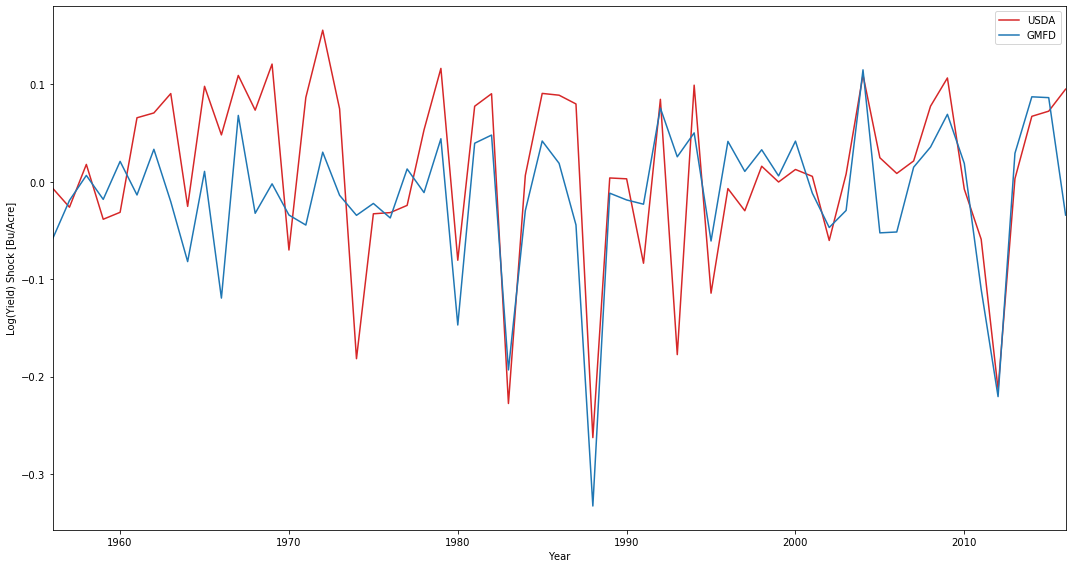

In [28]:
fig, ax = plt.subplots(1,1, figsize = (15,8))
ax.set_xlabel("Year")
ax.set_ylabel("Log(Yield) Shock [Bu/Acre]")
gmfd_national.reset_index().plot(x = "Year", y = "yield_USDA_nationally_weighted", ax = ax, label = "USDA", color = "C3")
gmfd_national.reset_index().plot(x = "Year", y = "yield_model_nationally_weighted", ax = ax, label = "GMFD", color = "C0")
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# Rank correlation
ss.spearmanr(gmfd_national["yield_USDA_nationally_weighted"], gmfd_national["yield_model_nationally_weighted"])

SpearmanrResult(correlation=0.5748810153358012, pvalue=1.2634184122066368e-06)

In [30]:
# Linear correlation
ss.pearsonr(gmfd_national["yield_USDA_nationally_weighted"], gmfd_national["yield_model_nationally_weighted"])

(0.6962469604125939, 4.665778733271506e-10)

In [33]:
# R^2
r2_score(gmfd_national["yield_USDA_nationally_weighted"][-38:], gmfd_national["yield_model_nationally_weighted"][-38:])

0.6132369192655361

In [36]:
# RMSE
np.sqrt(mean_squared_error(gmfd_national["yield_USDA_nationally_weighted"][:-11], gmfd_national["yield_model_nationally_weighted"][:-11]))

0.07340995955960362

In [37]:
# SD ratio
gmfd_national["yield_model_nationally_weighted"][:-11].std() / gmfd_national["yield_USDA_nationally_weighted"][:-11].std()

0.7790732210782713

### No significant differences!